In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability, log_probability_2flares, log_probability_2flares2ars
#from funcs.helper import calculate_inclination

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")


import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [13]:
#tstamp = '13_12_2019_10_18'
tstamp

'08_07_2020_11_48'

In [68]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

target = lcs.iloc[2]
i_mu, i_sigma = target.i_mu, target.i_sigma
target

ID                     44984200
QCS                          10
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                   custom
h_mission                  TESS
SpT                          M6
view_start              1587.25
view_stop               1589.75
view_min                   1620
view_max                   2200
BJDoff                  2457000
tstart                  1588.03
ampl_min                    0.5
ampl_max                    0.8
GRP                        1.54
plxmas                  90.0357
eplxmas                0.222697
RA                      129.508
Dec                    -58.9331
J                        10.309
R                         15.08
Gaia_G                  14.4115
vsini_kms               34.8422
e_vsini_kms                   3
Prot_d                    0.113
sini                        NaN
Ref                   this work
identifier       SCR J0838-5855
Rstar   

In [69]:
i_mu / np.pi*180, i_sigma / np.pi*180

(33.14284719337948, 1.6189412064138429)

TIC 44984200 modulation period:  2.712025530313231 h
Relative amplitude of modulation: 4.9e-03
[1569.43918221 1569.44057109 1569.44195997 ... 1595.67913614 1595.680525
 1595.68191386]
[8.676424 8.676424 8.676424 ... 8.676424 8.676424 8.676424]


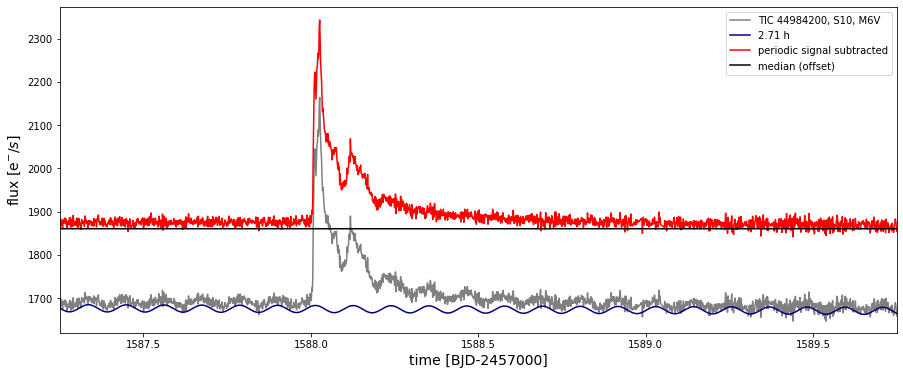

In [70]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
#from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False,)# cut=[target.view_start-5,target.view_stop+5])
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = F#refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                    # std_rolling_window_length=15, pad=25)

choice = (t > target.view_start +.6) & (t < target.view_stop-.25) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

In [71]:
len(phi)/900

1.3111111111111111

<ErrorbarContainer object of 3 artists>

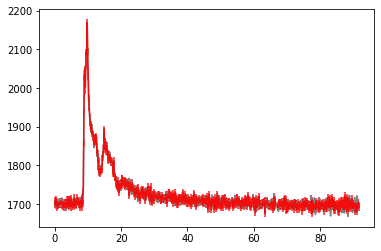

In [72]:
cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
plt.plot(cf.phi, cf.flux,color="grey")
plt.errorbar(cff.phi, cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
#plt.xlim(25,30)

In [73]:
cff

,phi,flux,t,flux_err,median_
phi,,,,,
"(-0.0917, 0.102]",0.038613,1704.102500,1587.850801,8.676423,1687.235558
"(0.102, 0.204]",0.154452,1708.601230,1587.852884,8.676423,1687.235558
"(0.204, 0.306]",0.231678,1698.012232,1587.854273,8.676423,1687.235558
"(0.306, 0.407]",0.347517,1695.328419,1587.856356,8.676423,1687.235558
"(0.407, 0.509]",0.463355,1711.745560,1587.858440,8.676423,1687.235558
...,...,...,...,...,...
"(91.158, 91.26]",91.203740,1702.081069,1589.490361,8.676423,1687.235558
"(91.26, 91.362]",91.319579,1702.679018,1589.492444,8.676423,1687.235558
"(91.362, 91.463]",91.435418,1704.158458,1589.494527,8.676423,1687.235558


In [74]:

# cff = cf.groupby(pd.cut(cf.phi, 200))
# plt.scatter(cf.phi, cf.flux,color="grey",s=1)
# plt.plot(cff.phi.mean(), cff.flux.mean()+cff.flux_err.mean(),color="k", alpha=.9)
# plt.plot(cff.phi.mean(), cff.flux.mean()-cff.flux_err.mean(),color="k", alpha=.9)
# plt.plot(cff.phi.mean(), cff.flux.mean()+2*cff.flux_err.mean(),color="k", alpha=.6)
# plt.plot(cff.phi.mean(), cff.flux.mean()-2*cff.flux_err.mean(),color="k", alpha=.6)
# plt.plot(cff.phi.mean(), cff.flux.mean()+3*cff.flux_err.mean(),color="k", alpha=.3)
# plt.plot(cff.phi.mean(), cff.flux.mean()-3*cff.flux_err.mean(),color="k", alpha=.3)

In [75]:
cff.dropna(how="any").to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

1687.2355579010703

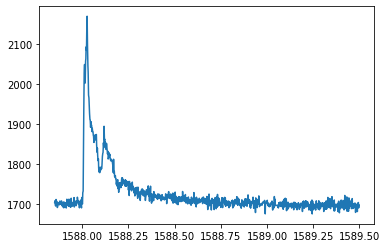

In [76]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(lc.t, lc.flux)

In [77]:
tstamp

'08_07_2020_11_48'

(1600.0, 2250.0)

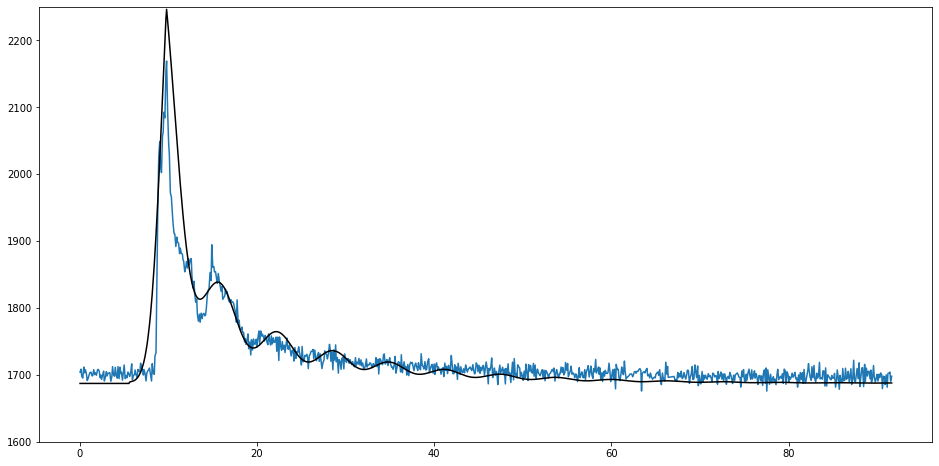

In [97]:

phi_a =9.8
theta_a = 65*np.pi/180#target.theta_a_init
a = .34
fwhm =  .15/target.Prot_d * 2 * np.pi
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = -150* np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(phi,flux)
# for i in range(-180,180,10):
#     plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i* np.pi / 180,
#                phi=phi, num_pts=50, qlum=qlum,
#                Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(1600,2250)

In [ ]:








### Save inits

In [98]:
log_probs = {"log_probability":[6, log_probability],
             "log_probability_2flares":[9, log_probability_2flares],
             "log_probability_2flares2ars":[10, log_probability_2flares2ars],}

log_prob = "log_probability"
nparam = log_probs[log_prob][0]

with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [ ]:
from funcs.flarefit import (log_probability,
                            log_probability_2flares,
                            log_probability_2flares2ars)

log_probs = {"log_probability":[6, log_probability],
             "log_probability_2flares":[9, log_probability_2flares],
             "log_probability_2flares2ars":[10, log_probability_2flares2ars],}






# Keyword arguments Nsteps = 50000

def run_mcmc(Nsteps=50000, wiggle=1e-3):

    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    target = inits.loc[inits.ID == ID,:]
    ndim = target.nparam
    nwalkers = 32


    inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
    pos = inits * (1. + wiggle * np.random.randn(nwalkers, target.nparam))

    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)


    sampler = emcee.EnsembleSampler(nwalkers, target.nparam, log_probability,
                                    args=(phi, flux, flux_err, target.qlum,
                                          target.Fth, target.R_Rsun, target.median,
                                          {"i_mu":target.i_mu,
                                          "i_sigma":target.i_sigma}),
                                    backend=backend)

    sampler.run_mcmc(pos, Nsteps, progress=True, store=True);



if __name__ == "__main__":
# Read ID from keyboard here

# 

In [ ]:
from funcs.flarefit import log_probability
ndim = 6
nwalkers = 32


inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(nwalkers, ndim))

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma}),
                                backend=backend)

In [ ]:
print(f"MCMC run at {tstamp}\n\nlight curve file: {filename}")

## Resume MCMC after break

In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
tstamp, target.ID

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, 
                                          qlum, Fth, R, median, 
                                          {"i_mu":i_mu, "i_sigma":i_sigma, }),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))